# Experiment 7 - Train models fine-tuning the VGG16 convolutional layers, pre-trained in ImageNet

In this experiment we train a VGG16-based model to perform classification using the Chest X-Ray dataset from Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). But this time freezing *just some* of the convolutional layers from the VGG16 pre-trained using the ImageNet dataset.

We'll perform the same steps as before to find the best performance as possible using this architecture, fine-tuning part of the VGG layers and training the fully-connected layers from zero.

The results obtained here will be used later to compare with the future experiments.

In [ ]:
%tensorflow_version 1.x
import os
import numpy as np
import tensorflow as tf
import random as rn
import keras
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from os import walk
from tqdm import *
from random import shuffle
from keras.utils import to_categorical
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Reshape, Conv2D, Dropout, Activation, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Set some variables to allow reproducibility

In [2]:
os.environ["PYTHONHASHSEED"] = "0"
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

## Download the flowers dataset from kaggle

### Set kaggle username and key

In [ ]:
os.environ["KAGGLE_USERNAME"] = "{username}"
os.environ["KAGGLE_KEY"] = "{key}"

### Download using the Kaggle API

https://www.kaggle.com/docs/api

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX/
!rm -rf chest_xray/chest_xray/

## Organize data and split into train, validation and test

In [ ]:
dataset_path = 'chest_xray'
for dset in ['train','val','test']:
    print('-----------------------')
    print('Set:', dset)
    set_path = os.path.join(dataset_path, dset)
    print(set_path)

    for (dirpath, dirnames, filenames) in walk(set_path):
        if (len(dirnames) > 0):
            folders_with_labels = np.empty([len(dirnames), 3], dtype=object)
            i = 0
            for dir_name in sorted(dirnames, key=str.lower):
                folders_with_labels[i][0] = dir_name
                folders_with_labels[i][1] = i
                folders_with_labels[i][2] = []
                i += 1
    print(folders_with_labels)

    # Fill image paths in the array from images in the folders
    for path, label, imgs in folders_with_labels:
        for (dirpath, dirnames, filenames) in walk(os.path.join(set_path, path)):
            for file_name in filenames:
                imgs.append('{}/{}/{},{}'.format(dset, path, file_name, label))

    print('')
    print("Total images per class...")
    total = 0
    for path, label, imgs in folders_with_labels:
        print(path, ":", len(imgs))
        total += len(imgs)
    print('')
    print('Total of images:', total)

    all_imgs = []
    for path, label, imgs in folders_with_labels:
        all_imgs.extend(imgs)
    print('images:', len(all_imgs))

    shuffle(all_imgs)

    with open(os.path.join(dataset_path, '{}.txt'.format(dset)), 'w') as f:  
        f.writelines("%s\n" % item for item in all_imgs)

-----------------------
Set: train
chest_xray/train
[['NORMAL' 0 list([])]
 ['PNEUMONIA' 1 list([])]]

Total images per class...
NORMAL : 1341
PNEUMONIA : 3875

Total of images: 5216
images: 5216
-----------------------
Set: val
chest_xray/val
[['NORMAL' 0 list([])]
 ['PNEUMONIA' 1 list([])]]

Total images per class...
NORMAL : 8
PNEUMONIA : 8

Total of images: 16
images: 16
-----------------------
Set: test
chest_xray/test
[['NORMAL' 0 list([])]
 ['PNEUMONIA' 1 list([])]]

Total images per class...
NORMAL : 234
PNEUMONIA : 390

Total of images: 624
images: 624


## 1 - Fine-tuning VGG16 with 2 FC layers

### Set initial parameters, functions and generators

Set parameters for our model and training

In [3]:
dataset_path = 'chest_xray'
width = 224
height = 224
input_shape = (width, height, 3)
batch_size = 10
verbose = 1
classes_dict = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}

Here we define 3 functions:


*   read_training_file() : Read the paths to images and labels for the dataset using each file (train, validation and test).
*   preprocess_image() : Preprocess the images in batch, set the size, the type and put in the TF format (scale pixels between -1 and 1).
*   data_generator() : Returns a generator that reads the images in batch and call the preprocess function, to be used in the training process with the fit_generator function.



In [4]:
def read_training_file(path, separator=' '):
    images = []
    labels = []
    with open(path, 'r') as f:
        for i in tqdm(f.readlines()):
            img_name, cls = i.strip().split(separator)
            cls = int(cls)
            images.append(img_name)
            labels.append(cls)
    return images, labels

def preprocess_image(images, images_path, width, height):
    pp_images = []

    for image in images:
        img = cv2.imread(os.path.join(images_path, image))
        if img.shape[0] != 224 or img.shape[1] != 224:
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
        img = np.asarray(img, 'float32')
        img = preprocess_input(img, mode='tf')
        pp_images.append(img)

    return np.asarray(pp_images)

def data_generator(images, labels, batch_size, images_path, width, height):
    batch_start = 0
    while batch_start < len(images):
        batch_end = min(batch_start + batch_size, len(images))
        y_batch = labels[batch_start : batch_end]
        x_batch = preprocess_image(images[batch_start : batch_end],
                                   images_path,
                                   width,
                                   height)
        batch_start += batch_size
        if batch_start >= len(images):
            batch_start = 0
        yield (x_batch, y_batch)

Read the label files (train, val and test) and set two arrays:

1.   paths to images.
2.   labels as a binary class matrix, for use with categorical_crossentropy.



In [5]:
train_path = os.path.join(dataset_path, 'train.txt')
val_path = os.path.join(dataset_path, 'val.txt')
test_path = os.path.join(dataset_path, 'test.txt')

train_images, train_labels = read_training_file(train_path, ',')
val_images, val_labels = read_training_file(val_path, ',')
test_images, test_labels = read_training_file(test_path, ',')

print('Train: {} documents'.format(len(train_images)))
print('Validation: {} documents'.format(len(val_images)))
print('Test: {} documents'.format(len(test_images)))

# train_labels_one_hot = to_categorical(train_labels)
# val_labels_one_hot = to_categorical(val_labels)
# test_labels_one_hot = to_categorical(test_labels)
# print(train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape)

100%|██████████| 624/624 [00:00<00:00, 232416.81it/s]

Train: 5216 documents
Validation: 16 documents
Test: 624 documents


Create generators for the training set and validation set.

In [6]:
# train_gen = data_generator(train_images, train_labels_one_hot, batch_size, dataset_path, width, height)
# val_gen = data_generator(val_images, val_labels_one_hot, batch_size, dataset_path, width, height)
train_gen = data_generator(train_images, train_labels, batch_size, dataset_path, width, height)
val_gen = data_generator(val_images, val_labels, batch_size, dataset_path, width, height)

num_batches_per_epoch = int(round(len(train_images) / float(batch_size)))
num_batches_per_epoch_val = int(round(len(val_images) / float(batch_size)))

### Define and compile the model architecture

In [7]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

### Set trainable and non-trainable layers

Here we are freezing the first 3 blocks of the VGG16 and set the rest of the layers in the model as trainable. The block4 and block5 of convolutions will be fine-tuned and the fully-connected layers will be trained from zero.

In [8]:
trainable_layers = ['block4', 'block5', 'fc', 'predictions']

for layer in model.layers:
  if any(_layer in layer.name for _layer in trainable_layers):
    layer.trainable = True
  else:
    layer.trainable = False
    
print('Not trainable')
for layer in model.layers:
  if not layer.trainable:
    print(layer.name + ': ' + str(layer))

print('')
print('Trainable')
for layer in model.layers:
  if layer.trainable:
    print(layer.name + ': ' + str(layer))


Not trainable
input_1: <keras.engine.input_layer.InputLayer object at 0x7fd465b887f0>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd465b88630>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7fd461234358>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fd461234eb8>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd461260828>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7fd461151198>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fd4611e7a58>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd461202390>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7fd46121e240>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7fd4610f1f28>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fd46110ce48>
flatten: <keras.layers.core.Flatten object at 0x7fd465b88fd0>

Trainable
block4_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd4611259b0>
block4_conv2: <kera

In [9]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the model.

In [10]:
num_epochs = 20

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

Start training...
Epoch 1/20
522/522 [==============================] - 105s 201ms/step - loss: 0.1005 - acc: 0.9642 - val_loss: 0.1786 - val_acc: 0.9375
Epoch 2/20
522/522 [==============================] - 102s 195ms/step - loss: 0.0365 - acc: 0.9900 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 3/20
522/522 [==============================] - 105s 201ms/step - loss: 0.0233 - acc: 0.9943 - val_loss: 9.0503e-05 - val_acc: 1.0000
Epoch 4/20
522/522 [==============================] - 105s 201ms/step - loss: 0.0108 - acc: 0.9975 - val_loss: 2.1556e-05 - val_acc: 1.0000
Epoch 5/20
522/522 [==============================] - 105s 202ms/step - loss: 0.0129 - acc: 0.9973 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 6/20
522/522 [==============================] - 105s 201ms/step - loss: 0.0137 - acc: 0.9979 - val_loss: 4.1981e-05 - val_acc: 1.0000
Epoch 7/20
522/522 [==============================] - 106s 203ms/step - loss: 0.0130 - acc: 0.9975 - val_loss: 4.3938e-05 - val_acc: 1.0000
Epoch 8/20
522

In [11]:
model.save('7_vgg16_fine_tuning_model1.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

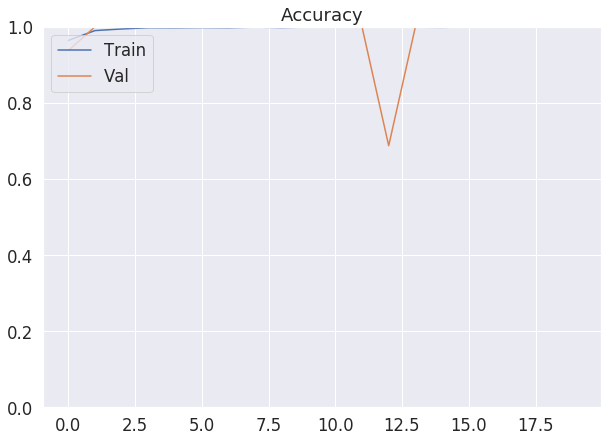

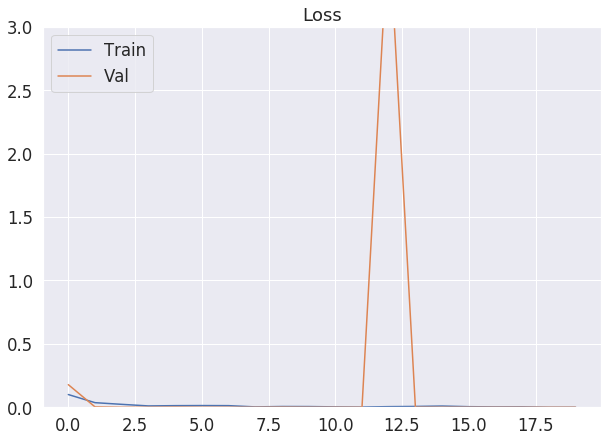

In [12]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [13]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

Evaluating trained model...
Finished mobilenet.evaluate_generator
['loss', 'acc']
[3.2722972354850643, 0.7774193483975625]


## 2 - Fine-tuning VGG16 with 2 FC layers + Regularization

### Define and compile the model architecture

In [17]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

### Set trainable and non-trainable layers

Here we are freezing the first 3 blocks of the VGG16 and set the rest of the layers in the model as trainable. The block4 and block5 of convolutions will be fine-tuned and the fully-connected layers will be trained from zero.

In [18]:
trainable_layers = ['block4', 'block5', 'fc', 'predictions']

for layer in model.layers:
  if any(_layer in layer.name for _layer in trainable_layers):
    layer.trainable = True
  else:
    layer.trainable = False
    
print('Not trainable')
for layer in model.layers:
  if not layer.trainable:
    print(layer.name + ': ' + str(layer))

print('')
print('Trainable')
for layer in model.layers:
  if layer.trainable:
    print(layer.name + ': ' + str(layer))


Not trainable
input_3: <keras.engine.input_layer.InputLayer object at 0x7fd3e6d03198>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd3e6d17ac8>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7fd3e6d2c0f0>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fd3e6cc02b0>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd3e6cd5630>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7fd3e7f272b0>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fd3e7f27ba8>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7fd3e7ec14e0>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7fd3e7ee0f60>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7fd3e7ef39b0>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fd3e7eab748>
flatten: <keras.layers.core.Flatten object at 0x7fd3e6cc0668>
dropout_3: <keras.layers.core.Dropout object at 0x7fd3e7d3ae48>
dropout_4: <keras.layers.core.Dropout obj

In [19]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model.

In [20]:
num_epochs = 20

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

Start training...
Epoch 1/20
522/522 [==============================] - 106s 204ms/step - loss: 0.1281 - acc: 0.9550 - val_loss: 0.0602 - val_acc: 1.0000
Epoch 2/20
522/522 [==============================] - 106s 203ms/step - loss: 0.0485 - acc: 0.9851 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 3/20
522/522 [==============================] - 105s 202ms/step - loss: 0.0213 - acc: 0.9933 - val_loss: 7.6543e-06 - val_acc: 1.0000
Epoch 4/20
522/522 [==============================] - 102s 196ms/step - loss: 0.0221 - acc: 0.9944 - val_loss: 2.0556e-04 - val_acc: 1.0000
Epoch 5/20
522/522 [==============================] - 104s 198ms/step - loss: 0.0125 - acc: 0.9960 - val_loss: 1.0213 - val_acc: 0.8750
Epoch 6/20
522/522 [==============================] - 102s 196ms/step - loss: 0.0113 - acc: 0.9969 - val_loss: 0.1328 - val_acc: 0.9375
Epoch 7/20
522/522 [==============================] - 104s 199ms/step - loss: 0.0079 - acc: 0.9981 - val_loss: 0.2646 - val_acc: 0.9375
Epoch 8/20
522/522 [==

In [21]:
model.save('7_vgg16_fine_tuning_model2.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

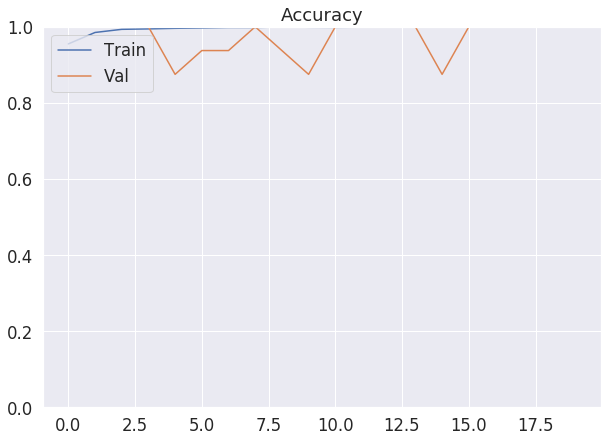

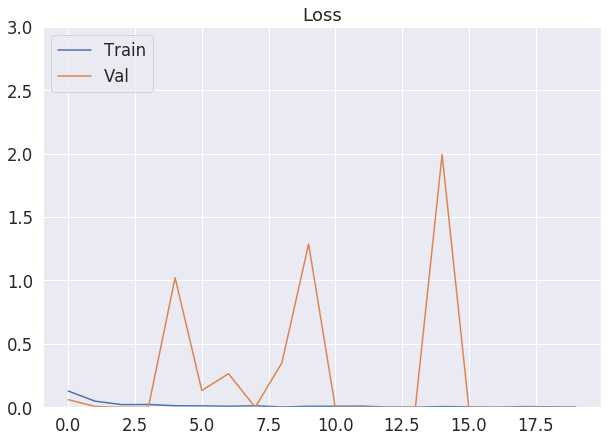

In [22]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [23]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

Evaluating trained model...
Finished model.evaluate_generator
['loss', 'acc']
[3.1561673658665805, 0.7903225767997003]


## 3 - Fine-tuning VGG16 with 2 FC layers + Regularization + Augmentation

### Create augmentation generator

Here we use the ImageDataGenerator from Keras to apply different types of augmentation.

In [7]:
image_gen = ImageDataGenerator(zoom_range=0.3,
                               #rotation_range=50,
                               #width_shift_range=0.2,
                               #height_shift_range=0.2,
                               #shear_range=0.01,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [8]:
def augmentation_generator(in_generator):

    for in_x, in_y in in_generator:
        g_x = image_gen.flow(in_x, in_y,
                             batch_size=in_x.shape[0])
        x, y = next(g_x)

        yield x, y

In [9]:
train_gen = augmentation_generator(train_gen)
val_gen = augmentation_generator(val_gen)

### Define and compile the model architecture

In [10]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Set trainable and non-trainable layers

Here we are freezing the first 3 blocks of the VGG16 and set the rest of the layers in the model as trainable. The block4 and block5 of convolutions will be fine-tuned and the fully-connected layers will be trained from zero.

In [11]:
trainable_layers = ['block4', 'block5', 'fc', 'predictions']

for layer in model.layers:
  if any(_layer in layer.name for _layer in trainable_layers):
    layer.trainable = True
  else:
    layer.trainable = False
    
print('Not trainable')
for layer in model.layers:
  if not layer.trainable:
    print(layer.name + ': ' + str(layer))

print('')
print('Trainable')
for layer in model.layers:
  if layer.trainable:
    print(layer.name + ': ' + str(layer))


Not trainable
input_1: <keras.engine.input_layer.InputLayer object at 0x7fceb47866a0>
block1_conv1: <keras.layers.convolutional.Conv2D object at 0x7fceb4786748>
block1_conv2: <keras.layers.convolutional.Conv2D object at 0x7fceb47869b0>
block1_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fceb47b0f98>
block2_conv1: <keras.layers.convolutional.Conv2D object at 0x7fceb47b0b00>
block2_conv2: <keras.layers.convolutional.Conv2D object at 0x7fceabf39668>
block2_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fceabfd79b0>
block3_conv1: <keras.layers.convolutional.Conv2D object at 0x7fceabfd7da0>
block3_conv2: <keras.layers.convolutional.Conv2D object at 0x7fceabec4438>
block3_conv3: <keras.layers.convolutional.Conv2D object at 0x7fceabee1860>
block3_pool: <keras.layers.pooling.MaxPooling2D object at 0x7fceabefbac8>
flatten: <keras.layers.core.Flatten object at 0x7fceb4786518>
dropout_1: <keras.layers.core.Dropout object at 0x7fceabd93710>
dropout_2: <keras.layers.core.Dropout obj

In [12]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the model.

In [13]:
num_epochs = 20

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

Start training...
Epoch 1/20
522/522 [==============================] - 175s 335ms/step - loss: 0.1902 - acc: 0.9257 - val_loss: 1.1869 - val_acc: 0.6875
Epoch 2/20
522/522 [==============================] - 165s 315ms/step - loss: 0.1068 - acc: 0.9615 - val_loss: 0.4499 - val_acc: 0.8125
Epoch 3/20
522/522 [==============================] - 170s 325ms/step - loss: 0.0925 - acc: 0.9655 - val_loss: 0.6461 - val_acc: 0.8125
Epoch 4/20
522/522 [==============================] - 170s 325ms/step - loss: 0.0795 - acc: 0.9745 - val_loss: 0.2114 - val_acc: 0.8750
Epoch 5/20
522/522 [==============================] - 173s 331ms/step - loss: 0.0732 - acc: 0.9736 - val_loss: 0.7625 - val_acc: 0.7500
Epoch 6/20
522/522 [==============================] - 175s 336ms/step - loss: 0.0704 - acc: 0.9768 - val_loss: 0.6927 - val_acc: 0.8125
Epoch 7/20
522/522 [==============================] - 173s 332ms/step - loss: 0.0648 - acc: 0.9778 - val_loss: 0.6330 - val_acc: 0.8750
Epoch 8/20
522/522 [==========

In [14]:
model.save('7_vgg16_fine_tuning_model3.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

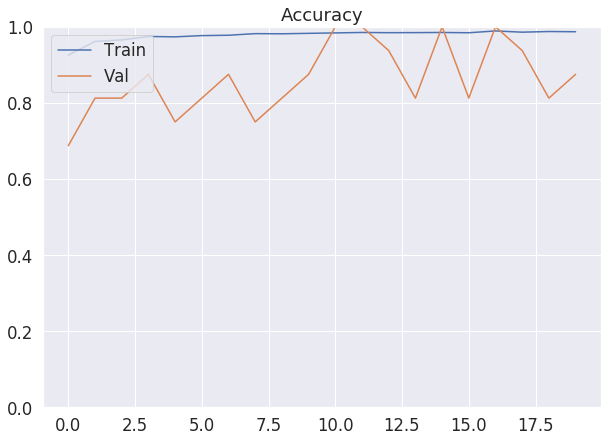

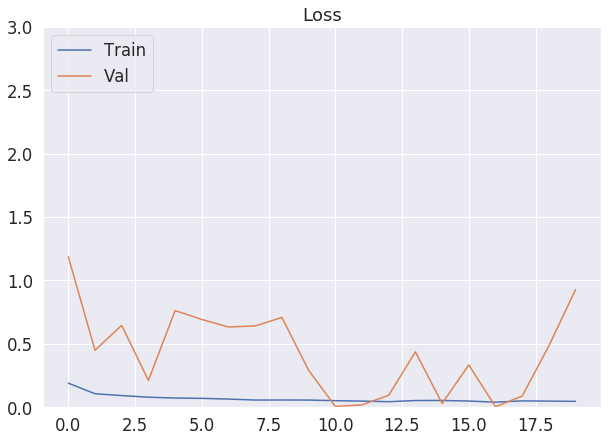

In [15]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [16]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

Evaluating trained model...
Finished model.evaluate_generator
['loss', 'acc']
[0.5643994614560979, 0.9274193471477877]
